In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')
#df = df.dropna()

## Visualising the Data

A movie database was used, cataloguing 5,000 different films. The database included information about the movies’ genres, keywords, title, synopsis, as well as cast and crew.

In [3]:
genres = dict()
genres_count = dict()
for r in df['genres']:
    r = json.loads(r)
    for d in r:
        genres[d['id']] = d['name']
        if d['name'] not in genres_count: genres_count[d['name']] = 1
        else: genres_count[d['name']] += 1
print(len(genres.keys()), max(genres.keys()))
print(genres)

20 10770
{28: 'Action', 12: 'Adventure', 14: 'Fantasy', 878: 'Science Fiction', 80: 'Crime', 18: 'Drama', 53: 'Thriller', 16: 'Animation', 10751: 'Family', 37: 'Western', 35: 'Comedy', 10749: 'Romance', 27: 'Horror', 9648: 'Mystery', 36: 'History', 10752: 'War', 10402: 'Music', 99: 'Documentary', 10769: 'Foreign', 10770: 'TV Movie'}


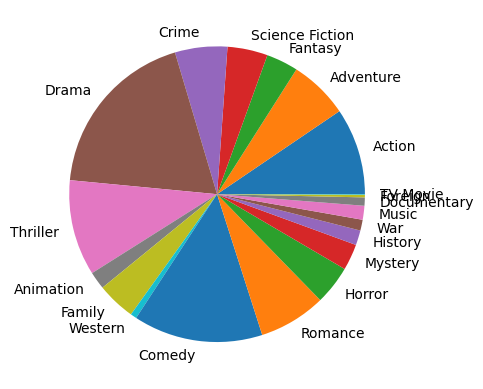

In [4]:
labels = list(genres_count.keys())
values = [genres_count[l] for l in labels]

plt.pie(values, labels=labels)
plt.show()

In [5]:
keywords = dict()
keywords_count = dict()
for r in df['keywords']:
    r = json.loads(r)
    for d in r:
        keywords[d['id']] = d['name']
        if d['name'] not in keywords_count: keywords_count[d['name']] = 1
        else: keywords_count[d['name']] += 1
print(len(keywords.keys()), max(keywords.keys()))

9813 238222


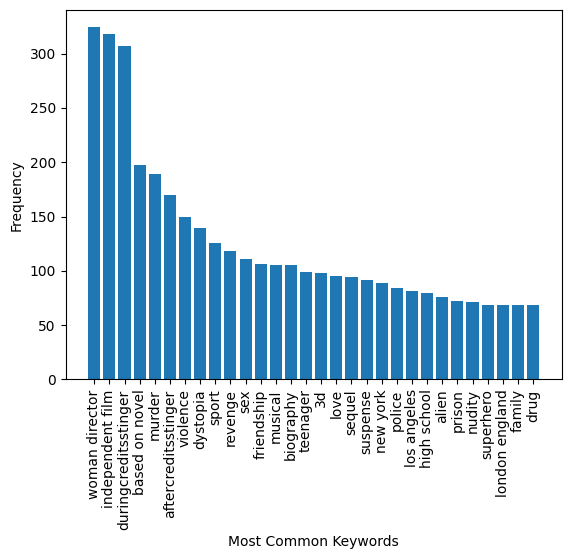

In [6]:
keys = [(cnt, key) for key, cnt in keywords_count.items()]
keys = sorted(keys)[::-1]
x = [keys[i][1] for i in range(30)]
h = [keys[i][0] for i in range(30)]

plt.bar(x, h)
plt.xticks(rotation=90)
plt.xlabel('Most Common Keywords')
plt.ylabel('Frequency')
plt.show()

## Content-Based Recommendations

### Bag-of-Words

Bag-of-words is a text model that ignores word order, focussing on the number of occurrences of each word. The movie synopses were encoded using a bag-of-words approach. First, the synopses were broken down into individual words and the occurrence of each word was counted across the database. The 50 most common words are listed below.

Most of these most common words give very little insight into the content of the film, so these words were disregarded. The next 10,000 most common words were included in the bag-of-words model.

In [7]:
bag_of_words = dict()
for r in df['overview']:
    r = str(r).lower()
    for word in r.split():
        if word not in bag_of_words:
            bag_of_words[word] = 1
        else:
            bag_of_words[word] += 1

word_freq = []
for word, freq in bag_of_words.items():
    word_freq.append((freq, word))
word_freq = sorted(word_freq)[::-1]
for i, w in word_freq[:50]:
    print(w, end=", ")

overview_encoding = dict()
for idx, item in enumerate(word_freq[50:10000]):
    freq, word = item
    overview_encoding[word] = idx

the, a, to, and, of, in, his, is, with, her, he, an, for, on, that, their, as, when, by, who, from, but, they, has, are, at, she, into, after, new, one, young, out, him, up, it, life, be, two, this, find, have, must, all, about, world, man, story, will, only, 

### Movie Encoding

Each movie was encoded by storing its genres, keywords, and synopsis words as separated bags-of-words. For simplicity, each word was either present or absent, rather than counting the number of occurrences.

In [8]:
def encode(row):
    g = set()
    for r in json.loads(row['genres']):
        g.add(r['id'])
    k = set()
    for r in json.loads(row['keywords']):
        k.add(r['id'])
    o = set()
    for r in str(row['overview']).lower().split():
        if r in overview_encoding:
            o.add(overview_encoding[r])
    return [g, k, o]  

In [9]:
d_movies = dict()
for idx, row in df.iterrows():
    d_movies[row['original_title']] = encode(row)

### Movie Similarity

A pair of movies can be assigned a similarity scored based on how many genres, keywords, and synopsis words they have in common. The genre was weighted the most heavily, and the synopsis words were weighted as the inverse of the number of words in the synopsis to prevent skewing the data with very long and very short synopses.

In [10]:
def similarity(a, b, w):
    score = 0
    for i in range(len(a)):
        for j in a[i]:
            if j in b[i]: score += w[i]
    return score

In [11]:
def get_most_similar(movie, n=10):
    recommend = []
    for m, data in d_movies.items():
        if m == movie: continue
        s = similarity(d_movies[m], d_movies[movie], [2,1,1/len(d_movies[movie][2])])
        recommend.append((s, m))
    recommend.sort()
    return recommend[-n:][::-1]

In [12]:
def get_recommendation(liked=[], disliked=[], n=10):
    recommend = []
    for m, data in d_movies.items():
        if m in liked or m in disliked: continue
        m_s = 0
        for movie in liked: m_s += similarity(d_movies[m], d_movies[movie], [2,1,1/len(d_movies[movie][2])])
        for movie in disliked: m_s -= similarity(d_movies[m], d_movies[movie], [2,1,1/len(d_movies[movie][2])])
        recommend.append((m_s, m))
    recommend.sort()
    return recommend[-n:][::-1]


In [13]:
def output(recom):
    print(f'{recom[0]:.1f}    {recom[1]}')

To sanity-check this procedure, the top 10 movies most similar to Batman Begins and Skyfall were generated. They are tabulated below, along with their similarity scores.

In [14]:
recommend = get_most_similar('Batman Begins')
for line in recommend: output(line)

15.1    The Dark Knight
13.0    The Dark Knight Rises
9.0    Batman & Robin
8.1    Batman Returns
8.1    Batman Forever
8.0    Teenage Mutant Ninja Turtles
8.0    Defendor
8.0    Blade
7.1    Brick Mansions
7.0    Batman v Superman: Dawn of Justice


In [15]:
recommend = get_most_similar('Skyfall')
for line in recommend: output(line)

9.0    The Spy Who Loved Me
8.1    Quantum of Solace
8.0    Never Say Never Again
8.0    Mission: Impossible
8.0    Dr. No
8.0    On Her Majesty's Secret Service
8.0    Diamonds Are Forever
7.1    Spectre
7.1    Mission: Impossible - Ghost Protocol
7.0    Tomorrow Never Dies


In [16]:
liked = ['Batman Begins', 'The Dark Knight', 'Memento', 'Inception', 'Alien']
disliked = ['The Dark Knight Rises', 'The Prestige', 'Cinderella']

recommend = get_recommendation(liked, disliked)
for line in recommend: output(line)

21.0    Green Lantern
20.2    Pandorum
20.1    Blade: Trinity
20.0    Aliens
19.1    Alien³
19.1    Starship Troopers
19.1    The Matrix Reloaded
19.1    X2
19.1    Planet of the Apes
19.0    Serenity


In [17]:
liked = ['The Theory of Everything', 'Persepolis', 'Dead Poets Society', 'Sicario']
disliked = ['Lost in Translation', 'The Wizard of Oz', 'The Hobbit: The Battle of the Five Armies']

recommend = get_recommendation(liked, disliked)
for line in recommend: output(line)

15.0    Lone Wolf McQuade
14.0    All Good Things
14.0    The Good German
14.0    Edge of Darkness
14.0    Disclosure
14.0    Wonderland
14.0    Lucky Number Slevin
14.0    Jindabyne
13.2    Class of 1984
13.1    Frailty


This recommendation algorithm can be refined by splitting the films into more refined categories, such as using a 5-star rating system. Films receiving 1 and 2 stars have a negative weighting (with 1 star having the lowest), whilst films receiving 3, 4, and 5 stars have progressively more positive weightings. 

In [18]:
def get_recommendation_ratings(ratings=dict(), n=10):
    rating_weights = [-3, -1.5, 1, 2, 3]
    recommend = []
    films = []
    for f in ratings.values(): films += f
    for m, data in d_movies.items():
        if m in films: continue
        m_s = 0
        for r in range(5):
            for movie in ratings[r+1]: m_s += rating_weights[r] * similarity(d_movies[m], d_movies[movie], [2,1,1/len(d_movies[movie][2])])
        recommend.append((m_s, m))
    recommend.sort()
    return recommend[-n:][::-1]

In [19]:
ratings = {1:['The Prestige', 'The Hobbit: The Battle of the Five Armies'], 2:['Lost in Translation', 'The Wizard of Oz'],
           3:['Batman Begins', 'Dead Poets Society'], 4:['Persepolis', 'Up'], 5:['Memento', 'The Theory of Everything']}

recommend = get_recommendation_ratings(ratings)
for line in recommend: output(line)

23.0    Anomalisa
21.5    Outside Providence
20.6    Inside Out
20.1    Confessions of a Dangerous Mind
20.0    Brooklyn's Finest
20.0    Arthur Christmas
19.0    When Harry Met Sally...
19.0    Ernest et Célestine
18.8    Good bye, Lenin!
18.4    Home Fries


## Conclusion

Content-based recommendation algorithms can suggest new movies to watch based on prior liked / disliked movies. A new movie is suggested if it has a high similarity to the liked films and a low similarity to the disliked films. Bag-of-words is an effective tool to estimate the similarity of two films by comparing overlapping words in the movies' genres, keywords, and synopses.